# Forecasting El Niño Southern Oscillation

##### Author: Luciana Nogueira de Paula Souza

\
\
The focus of this project is the El Niño-Southern Oscillation phenomenon. Given that this phenomenon has an irregular frequency and is not yet fully understood, the objective is to use Machine Learning models to attempt to predict future events of the phenomenon. Additionally, this study explores the hypothesis that solar activity may be a potential factor influencing this oscillation, by comparing models with and without the inclusion of this variable and evaluating the modeling results.

## Introduction

The El Niño phenomenon is monitored through various measurements in the Pacific Ocean: ocean temperature, atmospheric pressure, wind speed and direction, with the primary measurement being the sea surface temperature in the 3.4 region of the Pacific, known as the Niño 3.4 SST Index. This measure represents the average temperature variation in this region over the last 3 months. The El Niño phenomenon is considered present if this value is greater than 0.5°C, and if it is below -0.5°C, the index indicates the presence of La Niña.

The monthly records since 1950 were obtained from the NOAA/National Weather Service archives, through the page https://www.cpc.ncep.noaa.gov/products/precip/CWlink/MJO/enso.shtml, where several public databases are available.

Solar activity is determined by sunspots. Solar cycles last approximately 11 years and are measured by the number of observed sunspots, with the peak of activity being the period where the highest number of sunspots is observed. The solar activity data is represented by the monthly average of active sunspots and was obtained from the database of the Royal Observatory of Belgium, through the page https://www.sidc.be/SILSO/datafiles.


| Variable      | Description                    |
|---------------|--------------------------------|
| Y             | Year                           |
| MON           | Month                          |
| YR_dec        | Decimal Year                   |
| TOTAL         | Measured Temperature           |
| ClimAdjust    | Reference Temperature          |
| ANOM          | Anomaly = TOTAL-ClimAdjust     |
| spot_avg      | Monthly average spot number    |


The primary objective is to find a good modelling based on these data, enabling the prediction of the phenomenon through Machine Learning. The secondary objective of this study is to evaluate the hypothesis that solar activity may lead to a better model fit, demonstrating its importance as a factor in prediction. 

## Analysis

The code below loads the data, transforms the time series for supervised learning, trains the Random Forest and XGBoost models (with and without the additional solar activity variable) previously tuned using Grid Search Cross-Validation, evaluates the models, and visualizes the predictions in graphs.

I start importing the libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

### Understanding and Preparing the Data

I imported the El Niño and solar activity data from an Excel file into a dataframe:

In [2]:
enso = pd.read_excel('enso34m.xlsx')
enso.head()

,YR,MON,YR_dec,TOTAL,ClimAdjust,ANOM
0,1950,1,1950.042,24.56,26.18,-1.62
1,1950,2,1950.123,25.07,26.39,-1.32
2,1950,3,1950.204,25.88,26.95,-1.07
3,1950,4,1950.288,26.29,27.39,-1.11
4,1950,5,1950.371,26.19,27.56,-1.37


In [3]:
sun = pd.read_excel('SN_m_1950.xlsx')
sun.rename(columns={'M': 'MON'}, inplace=True)
sun.head()

,YR,MON,YR_dec,spot_avg
0,1950,1,1950.042,143.9
1,1950,2,1950.123,134.3
2,1950,3,1950.204,155.4
3,1950,4,1950.288,160.6
4,1950,5,1950.371,150.5


To facilitate the analysis, the dataframes were merged based on the time variables:

In [4]:
df = pd.merge(enso, sun, on=['YR', 'MON', 'YR_dec']).dropna()
df.head()

,YR,MON,YR_dec,TOTAL,ClimAdjust,ANOM,spot_avg
0,1950,1,1950.042,24.56,26.18,-1.62,143.9
1,1950,2,1950.123,25.07,26.39,-1.32,134.3
2,1950,3,1950.204,25.88,26.95,-1.07,155.4
3,1950,4,1950.288,26.29,27.39,-1.11,160.6
4,1950,5,1950.371,26.19,27.56,-1.37,150.5


Checking for missing data, and there are none:

In [5]:
df.isna().sum()

YR            0
MON           0
YR_dec        0
TOTAL         0
ClimAdjust    0
ANOM          0
spot_avg      0
dtype: int64

Let's visualize this time series:

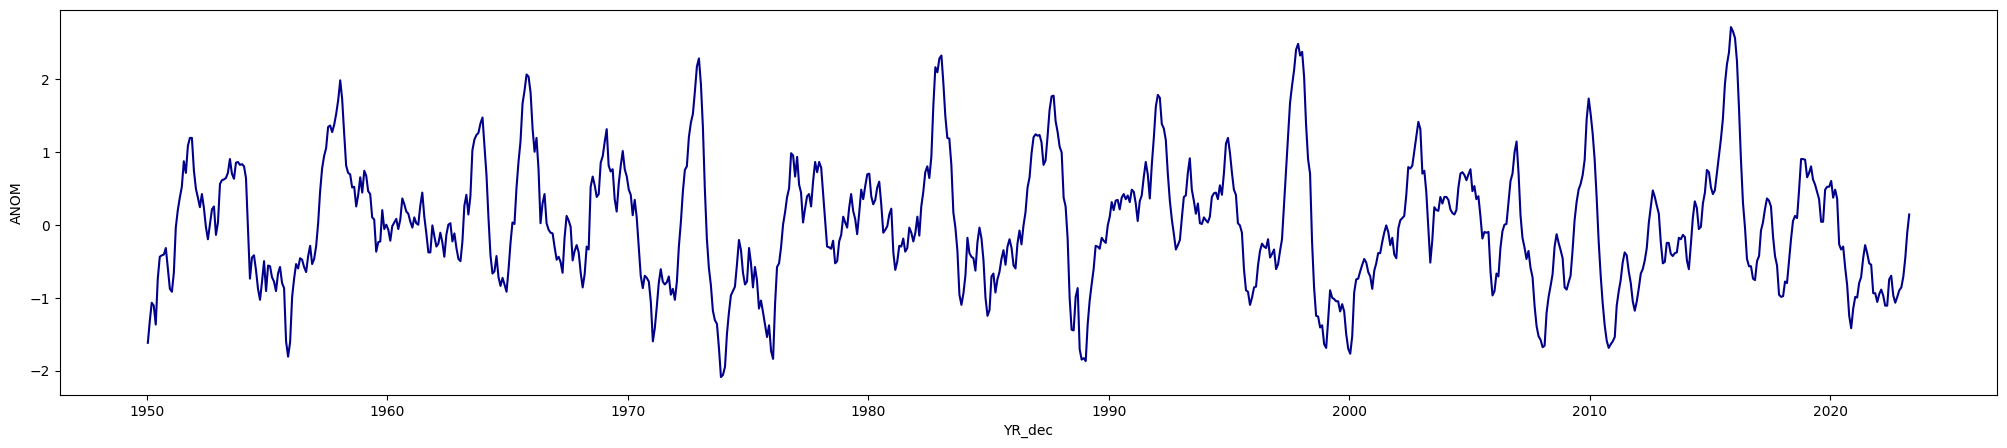

In [6]:
plt.figure(figsize=(25,5))
ax1 = sns.lineplot(data=df, x='YR_dec', y='ANOM', color='darkblue')
plt.show()

Now let's visualize the same series, identifying the periods of El Niño and La Niña, and including the solar activity time series in the same graph to have a comprehensive view of the situation under study.

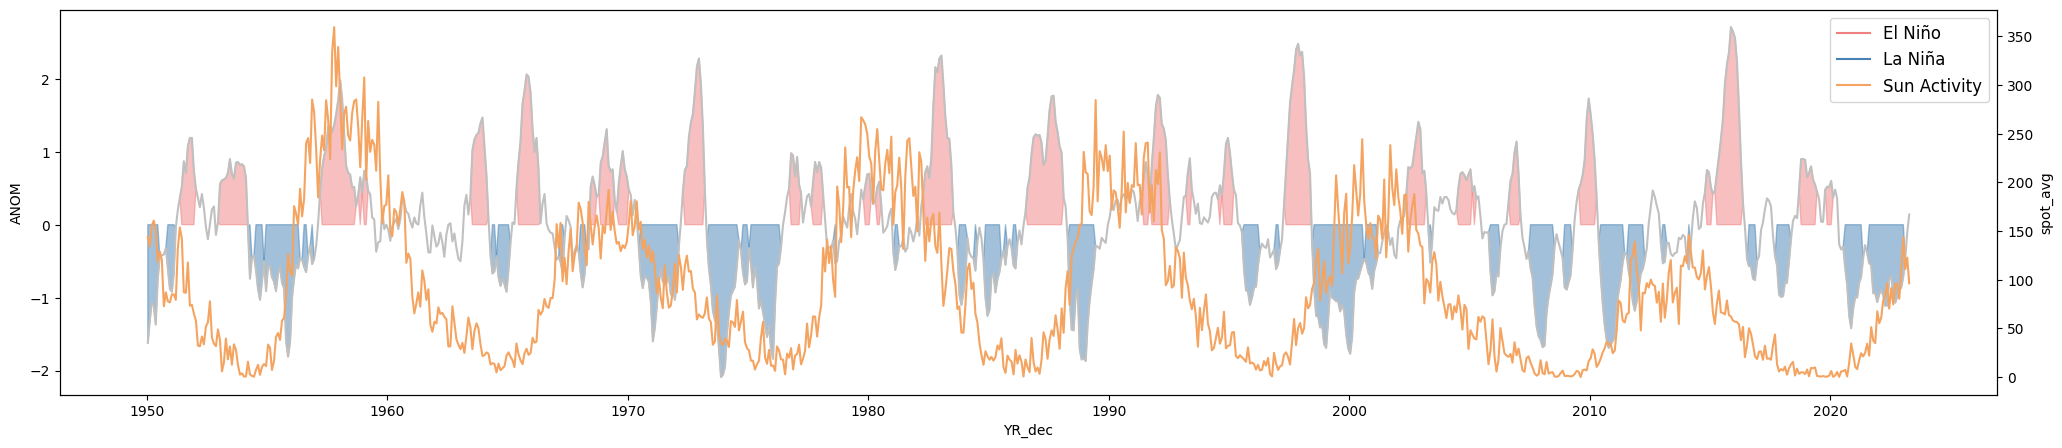

In [7]:
plt.figure(figsize=(25,5))

ax1 = sns.lineplot(data=df, x='YR_dec', y='ANOM', color='silver') #EL Niño

# Filling
x_values = df['YR_dec']
y_values = df['ANOM']
plt.fill_between(x_values, y_values, 0, where=(y_values > 0.5), interpolate=True, alpha=0.5, color='lightcoral')
plt.fill_between(x_values, y_values, 0, where=(y_values < -0.5), interpolate=True, alpha=0.5, color='steelblue')

# Sun Activity
ax2 = plt.twinx()
sns.lineplot(data=df, x='YR_dec', y='spot_avg', ax=ax2, color='sandybrown')

plt.legend(handles=[plt.Line2D([], [], color='lightcoral'), plt.Line2D([], [], color='steelblue'), plt.Line2D([], [], color='sandybrown')],
           labels=["El Niño", "La Niña", "Sun Activity"], loc='best', prop={'size': 'large'})
plt.show()

### Lag features

Since this analysis involves time series modeling, it is necessary to create lag features as variables.

A lag feature is a variable derived from previous values of a time series, used as input in predictive models. Essentially, it represents the value of a variable at one or more previous time points (lags), allowing the model to capture temporal patterns, such as trends or seasonality.

After some testing, I decided on these periods: 1, 2, 3; 6, 9, 12; 24, 36, 48; as a combination of short (monthly) lags, intermediate lags (to capture seasonal patterns), and long lags (potential patterns across years).

In [8]:
df['ANOM_t-1'] = df['ANOM'].shift(1)
df['ANOM_t-2'] = df['ANOM'].shift(2)
df['ANOM_t-3'] = df['ANOM'].shift(3)
df['ANOM_t-6'] = df['ANOM'].shift(6)
df['ANOM_t-9'] = df['ANOM'].shift(9)
df['ANOM_t-12'] = df['ANOM'].shift(12)
df['ANOM_t-24'] = df['ANOM'].shift(24)
df['ANOM_t-36'] = df['ANOM'].shift(36)
df['ANOM_t-48'] = df['ANOM'].shift(48)

I then defined the independent variables (X) and the target variable (y). The target of the study is the variable 'ANOM'. The dataset X1 contains only the lag features, without solar activity, while the dataset X2 includes solar activity 'spot_avg' in addition to the lag features.

In [9]:
X1 = df[['ANOM_t-1', 'ANOM_t-2','ANOM_t-3', 'ANOM_t-6', 'ANOM_t-9', 'ANOM_t-12', 'ANOM_t-24', 'ANOM_t-36', 'ANOM_t-48']]
y = df['ANOM']

In [10]:
X2 = df[['spot_avg', 'ANOM_t-1', 'ANOM_t-2','ANOM_t-3', 'ANOM_t-6', 'ANOM_t-9', 'ANOM_t-12', 'ANOM_t-24', 'ANOM_t-36', 'ANOM_t-48']]


### Grid Search Cross-Validation

To optimize the models' hyperparameters, I performed a Grid Search with cross-validation using the lag features dataset. The functions below perform the grid search and will be executed next.

In [11]:
def perform_grid_search(X, y, cv=3):
    """
    Grid Search with Cross Validation for Random Forest e XGBoost.
    Returns best hyperparameters for each model.
    """
    # Random Forest Grid Search
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf = RandomForestRegressor(random_state=44)
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=cv, scoring='neg_mean_squared_error')
    grid_search_rf.fit(X, y)
    best_params_rf = grid_search_rf.best_params_

    # XGBoost Grid Search
    param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
        'subsample': [0.7, 0.8, 0.9]
    }
    xgb = XGBRegressor(random_state=44)
    grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=cv, scoring='neg_mean_squared_error')
    grid_search_xgb.fit(X, y)
    best_params_xgb = grid_search_xgb.best_params_

    return best_params_rf, best_params_xgb


In [12]:
best_params1_rf, best_params1_xgb = perform_grid_search(X1, y) #SEM ATIVIDADE SOLAR

I tested applying the Grid Search on the datasets with and without solar activity, and the differences in hyperparameters were negligible. Therefore, I used the hyperparameters determined with the dataset without solar activity.

### Model Training and Evaluation

With the models well-configured, it is now possible to apply them to the data. The function below trains the Random Forest and XGBoost models on both datasets (with and without solar activity).

In [13]:
def train_with_optimized_params(X, y, best_params_rf, best_params_xgb, test_size=0.25, random_state=44):
    
    # Train and Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    #Train and Evaluate the Models:

    # Random Forest Optimized
    print("\nHyperparameters for Random Forest:")
    print(best_params_rf)
    rf_optimized = RandomForestRegressor(**best_params_rf, random_state=random_state)
    rf_optimized.fit(X_train, y_train)
    y_pred_rf = rf_optimized.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    # XGBoost Optimized
    print("\nHyperparameters for XGBoost:")
    print(best_params_xgb)
    xgb_optimized = XGBRegressor(**best_params_xgb, random_state=random_state)
    xgb_optimized.fit(X_train, y_train)
    y_pred_xgb = xgb_optimized.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)

    # Results
    return {
        'results': pd.DataFrame({
            'Model': ['Random Forest', 'XGBoost'],
            'MSE': [mse_rf, mse_xgb],
            'R²': [r2_rf, r2_xgb]
        }),
        'y_test': y_test,
        'y_pred_rf': y_pred_rf,
        'y_pred_xgb': y_pred_xgb
    }


### Results

Now we apply the function to the X1 and X2 datasets (y remains the same):

In [14]:
# Without Sun Activity
results_X1 = train_with_optimized_params(X1, y, best_params1_rf, best_params1_xgb)
print(results_X1['results'])


Hyperparameters for Random Forest:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Hyperparameters for XGBoost:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
           Model       MSE        R²
0  Random Forest  0.065580  0.898676
1        XGBoost  0.065094  0.899427


In [15]:
# With Sun Activity
results_X2 = train_with_optimized_params(X2, y, best_params1_rf, best_params1_xgb)
print(results_X2['results'])


Hyperparameters for Random Forest:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Hyperparameters for XGBoost:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
           Model       MSE        R²
0  Random Forest  0.066212  0.897698
1        XGBoost  0.065728  0.898447


### Visualization

Below, I have included a visual comparison of the predicted values versus the actual values for each model, in the X1 and X2 datasets.

To recap:

X1 - without solar activity\
X2 - with solar activity

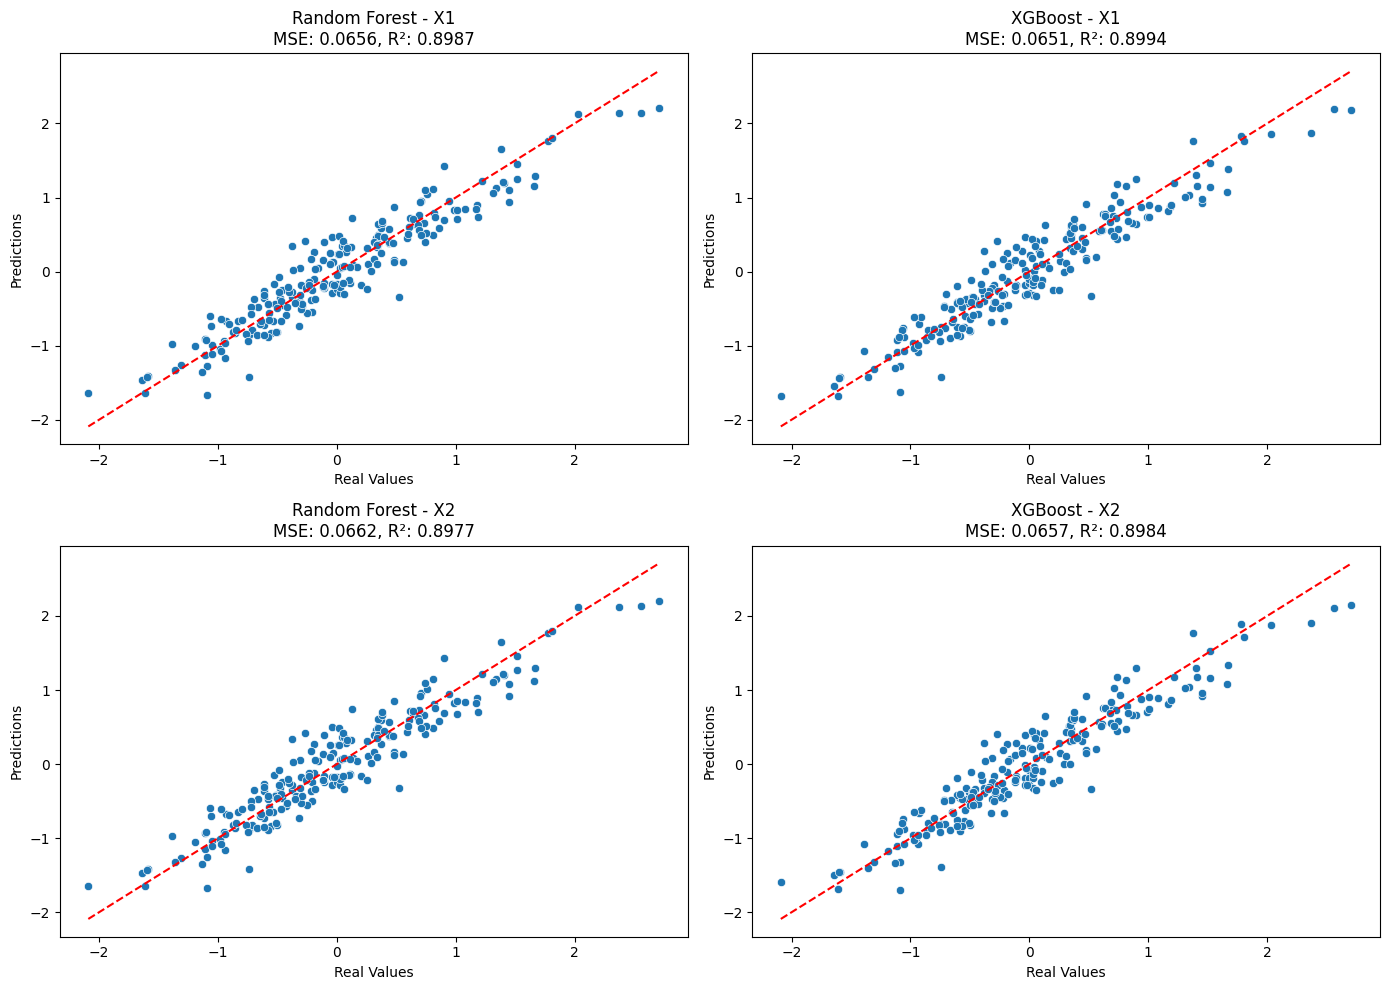

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Random Forest with X1
sns.scatterplot(x=results_X1['y_test'], y=results_X1['y_pred_rf'], ax=axs[0, 0])
axs[0, 0].plot([min(results_X1['y_test']), max(results_X1['y_test'])], [min(results_X1['y_test']), max(results_X1['y_test'])], color='red', linestyle='--')
axs[0, 0].set_title(f"Random Forest - X1\nMSE: {results_X1['results']['MSE'][0]:.4f}, R²: {results_X1['results']['R²'][0]:.4f}")

# Plot 2: XGBoost with X1
sns.scatterplot(x=results_X1['y_test'], y=results_X1['y_pred_xgb'], ax=axs[0, 1])
axs[0, 1].plot([min(results_X1['y_test']), max(results_X1['y_test'])], [min(results_X1['y_test']), max(results_X1['y_test'])], color='red', linestyle='--')
axs[0, 1].set_title(f"XGBoost - X1\nMSE: {results_X1['results']['MSE'][1]:.4f}, R²: {results_X1['results']['R²'][1]:.4f}")

# Plot 3: Random Forest with X2
sns.scatterplot(x=results_X2['y_test'], y=results_X2['y_pred_rf'], ax=axs[1, 0])
axs[1, 0].plot([min(results_X2['y_test']), max(results_X2['y_test'])], [min(results_X2['y_test']), max(results_X2['y_test'])], color='red', linestyle='--')
axs[1, 0].set_title(f"Random Forest - X2\nMSE: {results_X2['results']['MSE'][0]:.4f}, R²: {results_X2['results']['R²'][0]:.4f}")

# Plot 4: XGBoost with X2
sns.scatterplot(x=results_X2['y_test'], y=results_X2['y_pred_xgb'], ax=axs[1, 1])
axs[1, 1].plot([min(results_X2['y_test']), max(results_X2['y_test'])], [min(results_X2['y_test']), max(results_X2['y_test'])], color='red', linestyle='--')
axs[1, 1].set_title(f"XGBoost - X2\nMSE: {results_X2['results']['MSE'][1]:.4f}, R²: {results_X2['results']['R²'][1]:.4f}")


for ax in axs.flat:
    ax.set(xlabel='Real Values', ylabel='Predictions')

plt.tight_layout()
plt.show()

As observed in the graphs above, the differences in the models are very subtle. Numerically, the XGBoost model without solar activity showed the highest R² (0.8994) and the lowest MSE (0.0651), making it technically the best result. However, the other approaches yield very similar results.

## Conclusion

Although it is well established that solar activity influences Earth's climate in general, the results of this project showed that, within the context of the data and models used, the inclusion of the solar activity variable (spot_avg) did not lead to significant improvements in the predictive capability of the models.

However, this observation should not be interpreted as an absence of solar activity's influence on global climate or the El Niño phenomenon. On the contrary, the relationship between solar activity and Earth's climate is complex and multifaceted, operating on different temporal scales and interacting with a wide range of climatic and oceanic factors. The models used in this project captured only a portion of these interactions, and it is possible that the influence of solar activity is more subtle or indirect, manifesting in ways that were not fully captured by the data or the modeling approach adopted.

Furthermore, the fact that the models identified the same optimal hyperparameters regardless of the inclusion or exclusion of solar activity suggests that the modeling is robust and effective for the dataset analyzed. However, this also indicates that the nuances of the interaction between solar activity and El Niño may require more sophisticated modeling approaches.

In conclusion, the results of this project highlight the complexity of the climate and the importance of continuing to explore the role of multiple interconnected factors, such as solar activity, in the behavior of El Niño. Future investigations with more complex models that capture nonlinear interactions may reveal more about this climatic relationship.

## References

ENSO Data: https://www.cpc.ncep.noaa.gov/products/precip/CWlink/MJO/enso.shtml - NOAA/ National Weather Service \
https://en.wikipedia.org/wiki/El_Ni%C3%B1o%E2%80%93Southern_Oscillation \
https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/lanina/enso_evolution-status-fcsts-web.pdf \
Sun Activity Data: https://www.sidc.be/SILSO/datafiles - Royal Observatory of Belgium \
https://www.swpc.noaa.gov/phenomena/sunspotssolar-cycle \
https://soho.nascom.nasa.gov/sunspots/ \
Lag Features: https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html \
Grid Search CV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

